In [1]:
import pandas as pd
import numpy as np

import nltk
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import re
import emoji

import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import VarianceThreshold
from scipy import sparse
import sklearn.tree as tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


# Save Reddit Data

In [2]:
reddit_df = pd.read_csv('/Users/masonwasserman/Desktop/SML310/Final Project/reddit_wsb 2.csv')
reddit_df.head(5)

,title,score,id,url,comms_num,created,body,timestamp
0,"It's not about the money, it's about sending a...",55,l6ulcx,https://v.redd.it/6j75regs72e61,6,1.611863e+09,NaN,2021-01-28 21:37:41
1,Math Professor Scott Steiner says the numbers ...,110,l6uibd,https://v.redd.it/ah50lyny62e61,23,1.611862e+09,NaN,2021-01-28 21:32:10
2,Exit the system,0,l6uhhn,https://www.reddit.com/r/wallstreetbets/commen...,47,1.611862e+09,The CEO of NASDAQ pushed to halt trading “to g...,2021-01-28 21:30:35
3,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,29,l6ugk6,https://sec.report/Document/0001193125-21-019848/,74,1.611862e+09,NaN,2021-01-28 21:28:57
4,"Not to distract from GME, just thought our AMC...",71,l6ufgy,https://i.redd.it/4h2sukb662e61.jpg,156,1.611862e+09,NaN,2021-01-28 21:26:56


In [5]:
test =yf.download('GME')
test.head(10)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2002-02-13,9.625,10.060,9.525,10.050,6.766666,19054000
2002-02-14,10.175,10.195,9.925,10.000,6.733003,2755400
2002-02-15,10.000,10.025,9.850,9.950,6.699336,2097400
2002-02-19,9.900,9.900,9.375,9.550,6.430017,1852600
2002-02-20,9.600,9.875,9.525,9.875,6.648838,1723200
2002-02-21,9.840,9.925,9.750,9.850,6.632006,1744200
2002-02-22,9.925,9.925,9.600,9.675,6.514178,881400
2002-02-25,9.650,9.825,9.540,9.750,6.564678,863400
2002-02-26,9.700,9.850,9.545,9.750,6.564678,690400


# Preprocess

In [4]:
# Gets the part of speech tag of word for lemmatization
# This function is based on code from:
#   https://www.machinelearningplus.com/nlp/lemmatization-examples-python/

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def preprocess(text):
    text = text.replace('\n\n', ' ')  # get rid of new line markers
    text = emoji.demojize(text,  delimiters=(' ', ' '))  # turn emojis into text
    text = text.lower()  # make text lowercase
    text = re.sub(r'http\S+', '', text) # remove urls
    text = re.sub(r'[^\w\s]', '', text) # remove punctuation
    
    words = word_tokenize(text) # tokenize words
    stop_words = stopwords.words('english')
    
    filtered_words = [word for word in words if word not in stop_words] # remove stopwords
    
    lemmatizer = WordNetLemmatizer()
    lemma_words = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in filtered_words] # Lemmatize words
    return " ".join(lemma_words) # join string back together and return

def preprocess_df(df):
    idx1 = "title"
    idx2 = "body"
    length = len(df[idx1])
    for ii in range(length):
        text1 = str(df[idx1][ii])
        df.loc[ii, idx1] = preprocess(text1)
        text2 = str(df[idx2][ii])
        df.loc[ii, idx2] = preprocess(text2)
    return df
    

In [5]:
# Create copy of reddit_df to preprocess
pp_reddit_df = reddit_df.copy()
pp_reddit_df.fillna("", inplace=True) # fills any NaN values with empty strings
pp_reddit_df = preprocess_df(pp_reddit_df)

pp_reddit_df

,title,score,id,url,comms_num,created,body,timestamp
0,money send message rocket gem_stone raising_hands,55,l6ulcx,https://v.redd.it/6j75regs72e61,6,1.611863e+09,,2021-01-28 21:37:41
1,math professor scott steiner say number spell ...,110,l6uibd,https://v.redd.it/ah50lyny62e61,23,1.611862e+09,,2021-01-28 21:32:10
2,exit system,0,l6uhhn,https://www.reddit.com/r/wallstreetbets/commen...,47,1.611862e+09,ceo nasdaq push halt trading give investor cha...,2021-01-28 21:30:35
3,new sec filing gme someone less retard please ...,29,l6ugk6,https://sec.report/Document/0001193125-21-019848/,74,1.611862e+09,,2021-01-28 21:28:57
4,distract gme thought amc brother aware,71,l6ufgy,https://i.redd.it/4h2sukb662e61.jpg,156,1.611862e+09,,2021-01-28 21:26:56
...,...,...,...,...,...,...,...,...
45418,eric wife new boyfriend,49,mpdlqm,https://www.reddit.com/r/wallstreetbets/commen...,29,1.618262e+09,5g next market 5g get push news cycle due covi...,2021-04-13 00:15:06
45419,people,108,mpdq3f,https://www.reddit.com/gallery/mpdq3f,28,1.618263e+09,,2021-04-13 00:21:51
45420,wsb rule please read post,193,mpdluv,https://www.reddit.com/r/wallstreetbets/commen...,36,1.618262e+09,welcome wsb additional reading world wallstree...,2021-04-13 00:15:17
45421,buffett indicator flash againshould worried,521,mpd8c2,https://www.reddit.com/r/wallstreetbets/commen...,331,1.618261e+09,text lift yahoo mile udland lately buffett ind...,2021-04-12 23:54:14


## Save preprocessed data to csv file

In [6]:
pp_reddit_df.to_csv('/Users/masonwasserman/Desktop/SML310/Final Project/pp_reddit.csv')

### Load preprocessed data

In [6]:
pp_reddit_df = pd.read_csv('/Users/masonwasserman/Desktop/SML310/Final Project/pp_reddit.csv')
pp_reddit_df.fillna("", inplace=True)

#Add date column
numPosts = pp_reddit_df.shape[0]
for i in range(numPosts):
    pp_reddit_df.loc[i,'Date'] = pp_reddit_df.loc[i,'timestamp'].split()[0]
    
# Merge title and body text
pp_reddit_df["Text"] = pp_reddit_df["title"] + ' ' + pp_reddit_df["body"]

## Find training indices for GME, AMC, and SPY

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


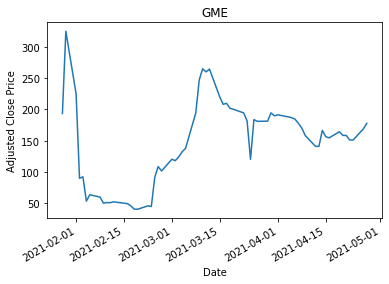

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


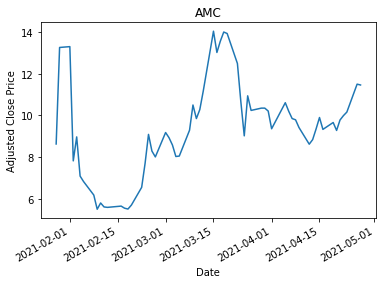

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


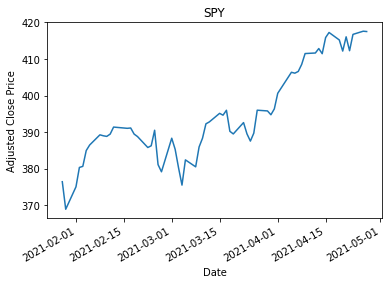

In [10]:
ticker = "GME"
x = yf.download(ticker)
x.index
newtime = yf.download(ticker, start = "2021-01-28", end = "2021-4-28")
newtime['Adj Close'].plot()
plt.xlabel("Date")
plt.ylabel("Adjusted Close Price")
plt.title(ticker)
plt.show()

ticker = "AMC"
x = yf.download(ticker)
x.index
newtime = yf.download(ticker, start = "2021-01-28", end = "2021-4-28")
newtime['Adj Close'].plot()
plt.xlabel("Date")
plt.ylabel("Adjusted Close Price")
plt.title(ticker)
plt.show()

ticker = "SPY"
x = yf.download(ticker)
x.index
newtime = yf.download(ticker, start = "2021-01-28", end = "2021-4-28")
newtime['Adj Close'].plot()
plt.xlabel("Date")
plt.ylabel("Adjusted Close Price")
plt.title(ticker)
plt.show()

In [11]:
# Find date range with even number of up and down movements for each stock
# GME
GME_start_date = '2021-03-01'
GME_end_date = '2021-04-28'
GME_train_indices = (pp_reddit_df['Date'] > GME_start_date) & (pp_reddit_df['Date'] <= GME_end_date)
GME_train_df = pp_reddit_df.loc[GME_train_indices]
GME_test_df = pp_reddit_df.loc[GME_train_indices == False]

# AMC
AMC_start_date = '2021-03-01'
AMC_end_date = '2021-04-28'
AMC_train_indices = (pp_reddit_df['Date'] > AMC_start_date) & (pp_reddit_df['Date'] <= AMC_end_date)
AMC_train_df = pp_reddit_df.loc[AMC_train_indices]
AMC_test_df = pp_reddit_df.loc[AMC_train_indices == False]

# SPY
SPY_start_date = '2021-02-15'
SPY_end_date = '2021-03-15'
SPY_train_indices = (pp_reddit_df['Date'] >= SPY_start_date) & (pp_reddit_df['Date'] <= SPY_end_date)
SPY_train_df = pp_reddit_df.loc[SPY_train_indices]
SPY_test_df = pp_reddit_df.loc[SPY_train_indices == False]


## Split data into trading days and non trading days

In [12]:
# Use Apple as example ticker to get trading days
tick = yf.download('AAPL', start = "2021-01-01", end = "2021-04-29")
ind = list(tick.index.strftime("%Y-%m-%d"))

# Create two df for trading days and non-trading days for each ticker

# GME
GME_trainTD_df = GME_train_df[GME_train_df['Date'].isin(ind)]
GME_trainNTD_df = GME_train_df[~GME_train_df['Date'].isin(ind)]

GME_testTD_df = GME_test_df[GME_test_df['Date'].isin(ind)]
GME_testNTD_df = GME_test_df[~GME_test_df['Date'].isin(ind)]

# AMC
AMC_trainTD_df = AMC_train_df[AMC_train_df['Date'].isin(ind)]
AMC_trainNTD_df = AMC_train_df[~AMC_train_df['Date'].isin(ind)]

AMC_testTD_df = AMC_test_df[AMC_test_df['Date'].isin(ind)]
AMC_testNTD_df = AMC_test_df[~AMC_test_df['Date'].isin(ind)]

# SPY
SPY_trainTD_df = SPY_train_df[SPY_train_df['Date'].isin(ind)]
SPY_trainNTD_df = SPY_train_df[~SPY_train_df['Date'].isin(ind)]

SPY_testTD_df = SPY_test_df[SPY_test_df['Date'].isin(ind)]
SPY_testNTD_df = SPY_test_df[~SPY_test_df['Date'].isin(ind)]

[*********************100%***********************]  1 of 1 completed


# Use bullish / bearish key words and make dataframes

In [13]:
bull_words=['call', 'long', 'all in', 'moon', 'going up', 'rocket', 'buy', 'long term', 'green']
bear_words=['put', 'short', 'going down', 'drop', 'bear', 'sell', 'red']
stocks = ['gme', 'amc']
key_words = bull_words + bear_words + stocks

key_word_df = pd.DataFrame()
for word in key_words:
    count = pp_reddit_df['Text'].str.count(word)
    key_word_df[word] = count


# GME
GME_trainTD_kw = key_word_df.loc[GME_trainTD_df.index]
GME_trainTD_kw = GME_trainTD_kw[GME_trainTD_kw['gme'] > 0].drop(['gme','amc'], axis=1)
GME_trainNTD_kw = key_word_df.loc[GME_trainNTD_df.index]
GME_trainNTD_kw = GME_trainNTD_kw[GME_trainNTD_kw['gme'] > 0].drop(['gme','amc'], axis=1)

GME_testTD_kw = key_word_df.loc[GME_testTD_df.index]
GME_testTD_kw = GME_testTD_kw[GME_testTD_kw['gme'] > 0].drop(['gme','amc'], axis=1)
GME_testNTD_kw = key_word_df.loc[GME_testNTD_df.index]
GME_testNTD_kw = GME_testNTD_kw[GME_testNTD_kw['gme'] > 0].drop(['gme','amc'], axis=1)

# AMC
AMC_trainTD_kw = key_word_df.loc[AMC_trainTD_df.index]
AMC_trainTD_kw = AMC_trainTD_kw[AMC_trainTD_kw['amc'] > 0].drop(['gme','amc'], axis=1)
AMC_trainNTD_kw = key_word_df.loc[AMC_trainNTD_df.index]
AMC_trainNTD_kw = AMC_trainNTD_kw[AMC_trainNTD_kw['amc'] > 0].drop(['gme','amc'], axis=1)

AMC_testTD_kw = key_word_df.loc[AMC_testTD_df.index]
AMC_testTD_kw = AMC_testTD_kw[AMC_testTD_kw['amc'] > 0].drop(['gme','amc'], axis=1)
AMC_testNTD_kw = key_word_df.loc[AMC_testNTD_df.index]
AMC_testNTD_kw = AMC_testNTD_kw[AMC_testNTD_kw['amc'] > 0].drop(['gme','amc'], axis=1)

# SPY
SPY_trainTD_kw = key_word_df.loc[SPY_trainTD_df.index].drop(['gme','amc'], axis=1)
SPY_trainNTD_kw = key_word_df.loc[SPY_trainNTD_df.index].drop(['gme','amc'], axis=1)

SPY_testTD_kw = key_word_df.loc[SPY_testTD_df.index].drop(['gme','amc'], axis=1)
SPY_testNTD_kw = key_word_df.loc[SPY_testNTD_df.index].drop(['gme','amc'], axis=1)


In [306]:
GME_trainTD_kw

,call,long,all in,moon,going up,rocket,buy,long term,green,put,short,going down,drop,bear,sell,red
36364,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
36373,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
36374,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
36375,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
36378,3,1,0,0,0,0,0,0,0,0,7,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45370,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
45382,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
45383,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
45404,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0


## Use trading days and non-trading days to create bag of words representation for title and body text

In [14]:
def match_features(train_vocab_df_text, test_vocab_df_text):
    # clean testing data to ensure it has the same columns as training data
    train_cols_text = np.array(train_vocab_df_text.columns)
    test_cols_text = np.array(test_vocab_df_text.columns)

    # find columns that are in both train and test
    intersection = np.intersect1d(train_cols_text, test_cols_text) 

    # remove data in test that does not appear in train
    test_copy = test_vocab_df_text.copy()
    test_copy = test_copy.drop(columns = intersection)
    cols = test_copy.columns
    test_vocab_df_text = test_vocab_df_text.drop(columns = cols)

    # add in dummy columns to test so that indices match training data
    train_copy = train_vocab_df_text.copy()
    train_copy = train_copy.drop(columns = intersection)

    cols = np.array(train_copy.columns)
    num_rows = test_vocab_df_text.shape[0]

    for x in cols:
        test_vocab_df_text[x] = np.zeros(num_rows)

    # sort columns of test data to ensure they are in same order as training data
    test_vocab_df_text = test_vocab_df_text.reindex(sorted(test_vocab_df_text.columns), axis=1)
    return test_vocab_df_text

In [15]:
# Uses a CountVectorizer to construct bag-of-words matrix  

# GME

# Trading Day
vectorizer = CountVectorizer() 
GME_trainTD_vocab = vectorizer.fit_transform(GME_trainTD_df['Text']).toarray()
GME_trainTD_vocab = pd.DataFrame(GME_trainTD_vocab, columns=vectorizer.get_feature_names())
GME_trainTD_vocab = GME_trainTD_vocab[GME_trainTD_vocab['gme'] > 0]

vectorizer = CountVectorizer() 
GME_testTD_vocab = vectorizer.fit_transform(GME_testTD_df['Text']).toarray()
GME_testTD_vocab = pd.DataFrame(GME_testTD_vocab, columns=vectorizer.get_feature_names())
GME_testTD_vocab = GME_testTD_vocab[GME_testTD_vocab['gme'] > 0]

# Non-Trading Day
vectorizer = CountVectorizer() 
GME_trainNTD_vocab = vectorizer.fit_transform(GME_trainNTD_df['Text']).toarray()
GME_trainNTD_vocab = pd.DataFrame(GME_trainNTD_vocab, columns=vectorizer.get_feature_names())
GME_trainNTD_vocab = GME_trainNTD_vocab[GME_trainNTD_vocab['gme'] > 0]

vectorizer = CountVectorizer() 
GME_testNTD_vocab = vectorizer.fit_transform(GME_testNTD_df['Text']).toarray()
GME_testNTD_vocab = pd.DataFrame(GME_testNTD_vocab, columns=vectorizer.get_feature_names())
GME_testNTD_vocab = GME_testNTD_vocab[GME_testNTD_vocab['gme'] > 0]

In [16]:
GME_trainTD_vocab

,000,00001,00007,0001,0001411579,0003,00035,0009,000yesredditors,001,...,𝖀𝖓𝖎𝖛𝖊𝖗𝖘𝖆𝖑,𝖉𝖊𝖒𝖔𝖓𝖘𝖙𝖗𝖆𝖓𝖉𝖚𝖒𝖇𝖉𝖚𝖒𝖇𝖘,𝖊𝖗𝖆𝖙,𝖔𝖋,𝖖𝖚𝖔𝖉,𝘽𝙪𝙨𝙞𝙣𝙚𝙨𝙨,𝙁𝙤𝙣𝙙𝙖𝙢𝙚𝙣𝙩𝙖𝙡𝙨,𝙈𝙮,𝙎𝙩𝙤𝙧𝙮,𝙩𝙝𝙤𝙪𝙜𝙝𝙩𝙨
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6838,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6850,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6851,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6872,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# AMC

# Trading Day
vectorizer = CountVectorizer() 
AMC_trainTD_vocab = vectorizer.fit_transform(AMC_trainTD_df['Text']).toarray()
AMC_trainTD_vocab = pd.DataFrame(AMC_trainTD_vocab, columns=vectorizer.get_feature_names())
AMC_trainTD_vocab = AMC_trainTD_vocab[AMC_trainTD_vocab['amc'] > 0]

vectorizer = CountVectorizer() 
AMC_testTD_vocab = vectorizer.fit_transform(AMC_testTD_df['Text']).toarray()
AMC_testTD_vocab = pd.DataFrame(AMC_testTD_vocab, columns=vectorizer.get_feature_names())
AMC_testTD_vocab = AMC_testTD_vocab[AMC_testTD_vocab['amc'] > 0]

# Non-Trading Day
vectorizer = CountVectorizer() 
AMC_trainNTD_vocab = vectorizer.fit_transform(AMC_trainNTD_df['Text']).toarray()
AMC_trainNTD_vocab = pd.DataFrame(AMC_trainNTD_vocab, columns=vectorizer.get_feature_names())
AMC_trainNTD_vocab = AMC_trainNTD_vocab[AMC_trainNTD_vocab['amc'] > 0]


vectorizer = CountVectorizer() 
AMC_testNTD_vocab = vectorizer.fit_transform(AMC_testNTD_df['Text']).toarray()
AMC_testNTD_vocab = pd.DataFrame(AMC_testNTD_vocab, columns=vectorizer.get_feature_names())
AMC_testNTD_vocab = AMC_testNTD_vocab[AMC_testNTD_vocab['amc'] > 0]

In [11]:
# SPY

# Trading Day
vectorizer = CountVectorizer() 
SPY_trainTD_vocab = vectorizer.fit_transform(SPY_trainTD_df['Text']).toarray()
SPY_trainTD_vocab = pd.DataFrame(SPY_trainTD_vocab, columns=vectorizer.get_feature_names())

vectorizer = CountVectorizer() 
SPY_testTD_vocab = vectorizer.fit_transform(SPY_testTD_df['Text']).toarray()
SPY_testTD_vocab = pd.DataFrame(SPY_testTD_vocab, columns=vectorizer.get_feature_names())

# Non-Trading Day
vectorizer = CountVectorizer() 
SPY_trainNTD_vocab = vectorizer.fit_transform(SPY_trainNTD_df['Text']).toarray()
SPY_trainNTD_vocab = pd.DataFrame(SPY_trainNTD_vocab, columns=vectorizer.get_feature_names())

vectorizer = CountVectorizer() 
SPY_testNTD_vocab = vectorizer.fit_transform(SPY_testNTD_df['Text']).toarray()
SPY_testNTD_vocab = pd.DataFrame(SPY_testNTD_vocab, columns=vectorizer.get_feature_names())


## Perform feature selection

In [12]:
# Function to perform variance thresholding feature selection on df
def VarThresh(thresh, df):
    VT = VarianceThreshold(thresh)
    VT.fit(df)
    return df[df.columns[VT.get_support(indices=True)]]

# Generate labels using given ticker

In [13]:
def labeler(ticker, df):
    labels = []
    stock_df = yf.download(ticker)
    indices = stock_df.index
    idx = 'Date'
    for i in df.index:
        date = df.loc[i, idx]
        open_price = stock_df.loc[date]['Open']
        close_price = stock_df.loc[date]['Close']
        labels.append((close_price - open_price) > 0)
    return np.array(labels)


## Create functions for classifiers

In [17]:
# Decision Tree Classifier
def DT(X_train, X_test, y_train, y_test):
    # Train decision tree classifier and predict using testing data
    clfDT = DecisionTreeClassifier(max_depth = 50, class_weight='balanced')
    scores = cross_val_score(clfDT, X_train, y_train, cv=5)
    
    clfDT = DecisionTreeClassifier(max_depth = 50, class_weight='balanced')
    clfDT = clfDT.fit(X_train,y_train)

    y_pred = clfDT.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    print("Decision Tree Classifier")
    
    print("5-fold average accuracy of %0.5f with a standard deviation of %0.5f" % (np.mean(scores), np.std(scores)))
    print(cm)
    print("Accuracy is", (tp + tn) / (tp + tn + fp + fn))
    print("Precision is", tp / (tp + fp))
    print("Recall / Sensitivity is", tp / (tp + fn))
    print("Specificity / Selectivity is", tn / (tn + fp))
    print("Proportion of positive is", np.mean(y_pred == 1))
    print("Proportion of actual positive is", np.mean(y_test == 1))
    
def RF(X_train, X_test, y_train, y_test):
    # Train decision tree classifier and predict using testing data
    clfRF = RandomForestClassifier(max_depth = 50, class_weight='balanced')
    scores = cross_val_score(clfRF, X_train, y_train, cv=5)
    
    clfRF = RandomForestClassifier(max_depth = 50, class_weight='balanced')
    clfRF = clfRF.fit(X_train,y_train)

    y_pred = clfRF.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    print("Random Forest Classifier")
    print("5-fold average accuracy of %0.5f with a standard deviation of %0.5f" % (np.mean(scores), np.std(scores)))
    print(cm)
    print("Accuracy is", (tp + tn) / (tp + tn + fp + fn))
    print("Precision is", tp / (tp + fp))
    print("Recall / Sensitivity is", tp / (tp + fn))
    print("Specificity / Selectivity is", tn / (tn + fp))
    print("Proportion of positive is", np.mean(y_pred == 1))
    print("Proportion of actual positive is", np.mean(y_test == 1))
    

def LR(X_train, X_test, y_train, y_test):
    # Train decision tree classifier and predict using testing data
    clfLR = LogisticRegression(max_iter = 1000, class_weight='balanced')
    scores = cross_val_score(clfLR, X_train, y_train, cv=5)
    
    clfLR = LogisticRegression(max_iter = 1000, class_weight='balanced')
    clfLR = clfLR.fit(X_train,y_train)

    y_pred = clfLR.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    print("Logistic Regression Classifier")
    print("5-fold average accuracy of %0.5f with a standard deviation of %0.5f" % (np.mean(scores), np.std(scores)))
    print(cm)
    print("Accuracy is", (tp + tn) / (tp + tn + fp + fn))
    print("Precision is", tp / (tp + fp))
    print("Recall / Sensitivity is", tp / (tp + fn))
    print("Specificity / Selectivity is", tn / (tn + fp))
    print("Proportion of positive is", np.mean(y_pred == 1))
    print("Proportion of actual positive is", np.mean(y_test == 1))
    
    
def KNN(X_train, X_test, y_train, y_test):
    # Train decision tree classifier and predict using testing data
    clfKNN = KNeighborsClassifier()
    scores = cross_val_score(clfKNN, X_train, y_train, cv=5)  
    
    clfKNN = KNeighborsClassifier()
    clfKNN = clfKNN.fit(X_train,y_train)

    y_pred = clfKNN.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    print("K Neighrest Neighbors Classifier")
    print("5-fold average accuracy of %0.5f with a standard deviation of %0.5f" % (np.mean(scores), np.std(scores)))
    print(cm)
    print("Accuracy is", (tp + tn) / (tp + tn + fp + fn))
    print("Precision is", tp / (tp + fp))
    print("Recall / Sensitivity is", tp / (tp + fn))
    print("Specificity / Selectivity is", tn / (tn + fp))
    print("Proportion of positive is", np.mean(y_pred == 1))
    print("Proportion of actual positive is", np.mean(y_test == 1))

# Generate Labels for Key Words

In [22]:
# GME
GME_Xtrain = GME_trainTD_kw.to_numpy()
GME_Xtest = GME_testTD_kw.to_numpy()

GME_Ytrain = labeler('GME',GME_trainTD_df.loc[GME_trainTD_kw.index])
GME_Ytest = labeler('GME', GME_testTD_df.loc[GME_testTD_kw.index])

# AMC
AMC_Xtrain = AMC_trainTD_kw.to_numpy()
AMC_Xtest = AMC_testTD_kw.to_numpy()

AMC_Ytrain = labeler('AMC',AMC_trainTD_df.loc[AMC_trainTD_kw.index])
AMC_Ytest = labeler('AMC', AMC_testTD_df.loc[AMC_testTD_kw.index])

# SPY
SPY_Xtrain = SPY_trainTD_kw.to_numpy()
SPY_Xtest = SPY_testTD_kw.to_numpy()

SPY_Ytrain = labeler('SPY',SPY_trainTD_df.loc[SPY_trainTD_kw.index])
SPY_Ytest = labeler('SPY', SPY_testTD_df.loc[SPY_testTD_kw.index])


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [16]:
print(GME_Ytest.mean())
print(GME_Ytrain.mean())
print()
print(AMC_Ytest.mean())
print(AMC_Ytrain.mean())
print()
print(SPY_Ytest.mean())
print(SPY_Ytrain.mean())

0.13165862958394078
0.5888389993585632

0.08817960508520421
0.2616580310880829

0.25648748841519925
0.4229141475211608


GME
Decision Tree Classifier
5-fold average accuracy of 0.48362 with a standard deviation of 0.04675
[[4174 3569]
 [ 647  527]]
Accuracy is 0.5271952450375686
Precision is 0.128662109375
Recall / Sensitivity is 0.4488926746166951
Specificity / Selectivity is 0.5390675448792458
Proportion of positive is 0.45934731411909835
Proportion of actual positive is 0.13165862958394078

AMC
Decision Tree Classifier
5-fold average accuracy of 0.62691 with a standard deviation of 0.03649
[[2380  991]
 [ 246   80]]
Accuracy is 0.6654043819312957
Precision is 0.07469654528478058
Recall / Sensitivity is 0.24539877300613497
Specificity / Selectivity is 0.7060219519430436
Proportion of positive is 0.28969434676764944
Proportion of actual positive is 0.08817960508520421

SPY
Decision Tree Classifier
5-fold average accuracy of 0.54111 with a standard deviation of 0.00981
[[17956  4507]
 [ 5899  1850]]
Accuracy is 0.655567324242023
Precision is 0.29101777568035236
Recall / Sensitivity is 0.23874048264292166

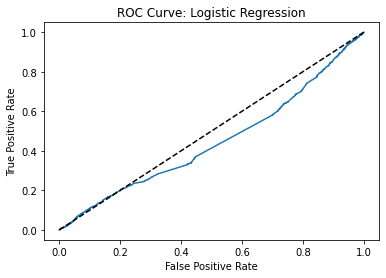


AMC
Logistic Regression Classifier
5-fold average accuracy of 0.56980 with a standard deviation of 0.10959
[[2869  502]
 [ 251   75]]
Accuracy is 0.7963213416283473
Precision is 0.12998266897746968
Recall / Sensitivity is 0.23006134969325154
Specificity / Selectivity is 0.851082764758232
Proportion of positive is 0.15607249120908845
Proportion of actual positive is 0.08817960508520421


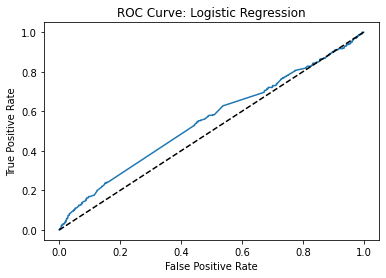


SPY
Logistic Regression Classifier
5-fold average accuracy of 0.55079 with a standard deviation of 0.02161
[[17404  5059]
 [ 6019  1730]]
Accuracy is 0.6333245068184827
Precision is 0.25482397996759465
Recall / Sensitivity is 0.22325461349851594
Specificity / Selectivity is 0.774785202332725
Proportion of positive is 0.2247120349529988
Proportion of actual positive is 0.25648748841519925


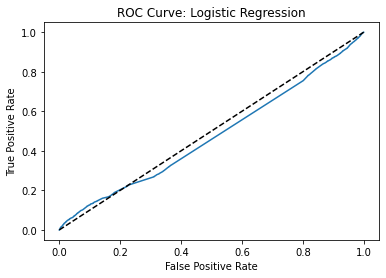

GME
K Neighrest Neighbors Classifier
5-fold average accuracy of 0.51122 with a standard deviation of 0.01063
[[3553 4190]
 [ 527  647]]
Accuracy is 0.47101042951665356
Precision is 0.13376059541037832
Recall / Sensitivity is 0.551107325383305
Specificity / Selectivity is 0.45886607258168666
Proportion of positive is 0.5424470113266794
Proportion of actual positive is 0.13165862958394078

AMC
K Neighrest Neighbors Classifier
5-fold average accuracy of 0.64289 with a standard deviation of 0.08146
[[3274   97]
 [ 312   14]]
Accuracy is 0.8893697592642683
Precision is 0.12612612612612611
Recall / Sensitivity is 0.04294478527607362
Specificity / Selectivity is 0.9712251557401365
Proportion of positive is 0.030024344062753585
Proportion of actual positive is 0.08817960508520421

SPY
K Neighrest Neighbors Classifier
5-fold average accuracy of 0.52132 with a standard deviation of 0.05051
[[18227  4236]
 [ 6191  1558]]
Accuracy is 0.6548722361975374
Precision is 0.26889886089057646
Recall / Sen

In [17]:
# Decision Tree
print("GME")
DT(GME_Xtrain, GME_Xtest, GME_Ytrain, GME_Ytest)
print()

print("AMC")
DT(AMC_Xtrain, AMC_Xtest, AMC_Ytrain, AMC_Ytest)
print()

print("SPY")
DT(SPY_Xtrain, SPY_Xtest, SPY_Ytrain, SPY_Ytest)

# Random Forest
print("GME")
RF(GME_Xtrain, GME_Xtest, GME_Ytrain, GME_Ytest)
print()

print("AMC")
RF(AMC_Xtrain, AMC_Xtest, AMC_Ytrain, AMC_Ytest)
print()

print("SPY")
RF(SPY_Xtrain, SPY_Xtest, SPY_Ytrain, SPY_Ytest)

# Logistic Regression
print("GME")
LR(GME_Xtrain, GME_Xtest, GME_Ytrain, GME_Ytest)
print()

print("AMC")
LR(AMC_Xtrain, AMC_Xtest, AMC_Ytrain, AMC_Ytest)
print()

print("SPY")
LR(SPY_Xtrain, SPY_Xtest, SPY_Ytrain, SPY_Ytest)

# KNN
print("GME")
KNN(GME_Xtrain, GME_Xtest, GME_Ytrain, GME_Ytest)
print()

print("AMC")
KNN(AMC_Xtrain, AMC_Xtest, AMC_Ytrain, AMC_Ytest)
print()

print("SPY")
KNN(SPY_Xtrain, SPY_Xtest, SPY_Ytrain, SPY_Ytest)

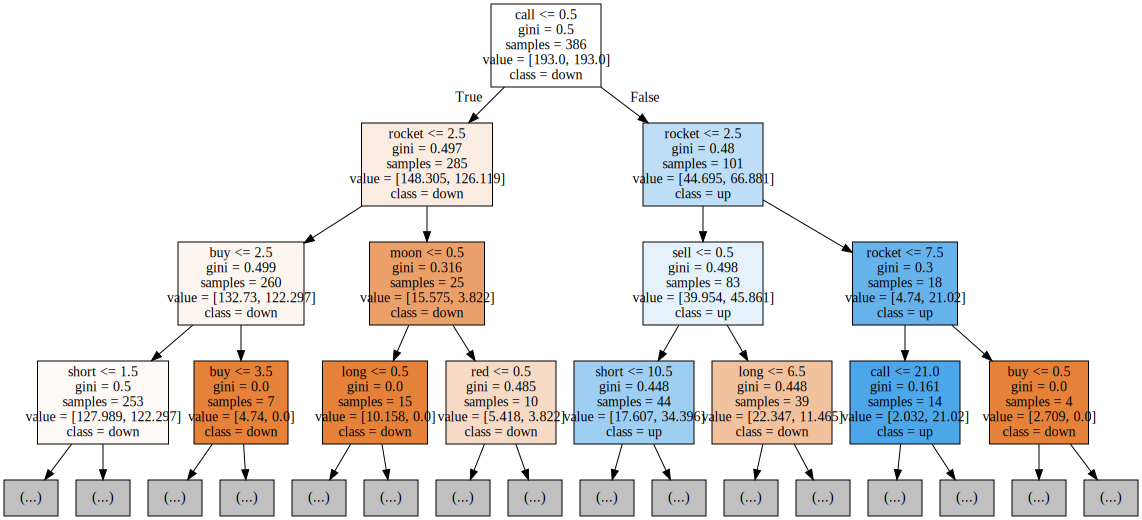

In [26]:
import graphviz
clfDT = DecisionTreeClassifier(max_depth = 50, class_weight='balanced')
clfDT = clfDT.fit(AMC_Xtrain, AMC_Ytrain)
data_out =tree.export_graphviz(clfDT, max_depth = 3, out_file = None,
                                feature_names = AMC_trainTD_kw.columns, 
                                class_names = ['down', 'up'],
                               filled = True)

graph = graphviz.Source(data_out)
graph

# Feature Select and Generate Labels for Bag of Words

In [18]:
# GME
GME_Xtrain = VarThresh(0.01,GME_trainTD_vocab)
GME_Xtest = match_features(GME_Xtrain, GME_testTD_vocab).to_numpy()
GME_Xtrain = GME_Xtrain.to_numpy()

GME_Ytrain = labeler('GME',GME_trainTD_df.iloc[GME_trainTD_vocab.index])
GME_Ytest = labeler('GME', GME_testTD_df.iloc[GME_testTD_vocab.index])

# AMC
AMC_Xtrain = VarThresh(0.01,AMC_trainTD_vocab)
AMC_Xtest = match_features(AMC_Xtrain, AMC_testTD_vocab).to_numpy()
AMC_Xtrain = AMC_Xtrain.to_numpy()

AMC_Ytrain = labeler('AMC',AMC_trainTD_df.iloc[AMC_trainTD_vocab.index])
AMC_Ytest = labeler('AMC',AMC_testTD_df.iloc[AMC_testTD_vocab.index])

# SPY
ls = []
for col in SPY_trainTD_vocab.columns:
    if SPY_trainTD_vocab[col].var() < 0.01:
        ls.append(col)

SPY_Xtrain = SPY_trainTD_vocab.drop(ls, axis=1)
SPY_Xtest = match_features(SPY_Xtrain, SPY_testTD_vocab).to_numpy()
SPY_Xtrain = SPY_Xtrain.to_numpy()

SPY_Ytrain = labeler('SPY',SPY_trainTD_df.iloc[SPY_trainTD_vocab.index])
SPY_Ytest = labeler('SPY', SPY_testTD_df.iloc[SPY_testTD_vocab.index])
# # Generate test/ train split
# XT_train, XT_test, yT_train, yT_test = train_test_split(XT, YT)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [19]:
print(GME_Ytest.mean())
print(GME_Ytrain.mean())
print()
print(AMC_Ytest.mean())
print(AMC_Ytrain.mean())
print()
print(SPY_Ytest.mean())
print(SPY_Ytrain.mean())

0.13101389367321162
0.5882352941176471

0.08863252673044457
0.2682926829268293

0.25648748841519925
0.4229141475211608


GME
Decision Tree Classifier
5-fold average accuracy of 0.51202 with a standard deviation of 0.05288
[[5030 2538]
 [ 605  536]]
Accuracy is 0.6391089677345275
Precision is 0.17436564736499674
Recall / Sensitivity is 0.4697633654688869
Specificity / Selectivity is 0.6646405919661733
Proportion of positive is 0.3529681938224825
Proportion of actual positive is 0.13101389367321162

AMC
Decision Tree Classifier
5-fold average accuracy of 0.60955 with a standard deviation of 0.07544
[[2376  863]
 [ 238   77]]
Accuracy is 0.6902082160945414
Precision is 0.08191489361702127
Recall / Sensitivity is 0.24444444444444444
Specificity / Selectivity is 0.7335597406606977
Proportion of positive is 0.2644907146876759
Proportion of actual positive is 0.08863252673044457

SPY
Decision Tree Classifier
5-fold average accuracy of 0.55668 with a standard deviation of 0.02425
[[18399  4064]
 [ 5880  1869]]
Accuracy is 0.670859261220707
Precision is 0.315017697623462
Recall / Sensitivity is 0.2411924119241192

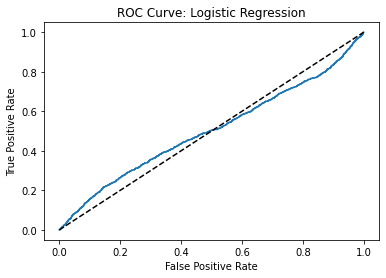


AMC
Logistic Regression Classifier
5-fold average accuracy of 0.64754 with a standard deviation of 0.04073
[[2855  384]
 [ 261   54]]
Accuracy is 0.8185143500281373
Precision is 0.1232876712328767
Recall / Sensitivity is 0.17142857142857143
Specificity / Selectivity is 0.8814448903982711
Proportion of positive is 0.12324141812042769
Proportion of actual positive is 0.08863252673044457


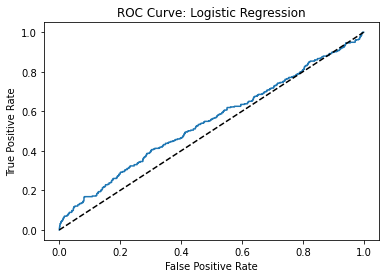


SPY
Logistic Regression Classifier
5-fold average accuracy of 0.51678 with a standard deviation of 0.02192
[[14343  8120]
 [ 4541  3208]]
Accuracy is 0.5809281080365418
Precision is 0.2831920903954802
Recall / Sensitivity is 0.41398890179377984
Specificity / Selectivity is 0.6385166718603926
Proportion of positive is 0.37495035085396533
Proportion of actual positive is 0.25648748841519925


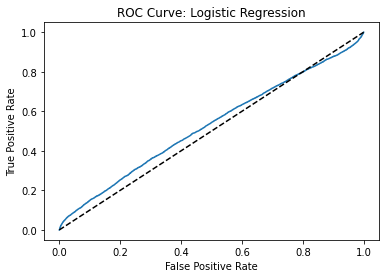

GME
K Neighrest Neighbors Classifier
5-fold average accuracy of 0.53806 with a standard deviation of 0.03080
[[1786 5782]
 [ 299  842]]
Accuracy is 0.3017568033069239
Precision is 0.12711352657004832
Recall / Sensitivity is 0.7379491673970202
Specificity / Selectivity is 0.23599365750528542
Proportion of positive is 0.760592490527041
Proportion of actual positive is 0.13101389367321162

AMC
K Neighrest Neighbors Classifier
5-fold average accuracy of 0.68567 with a standard deviation of 0.02106
[[3098  141]
 [ 300   15]]
Accuracy is 0.8759144625773776
Precision is 0.09615384615384616
Recall / Sensitivity is 0.047619047619047616
Specificity / Selectivity is 0.9564680456931152
Proportion of positive is 0.04389420371412493
Proportion of actual positive is 0.08863252673044457

SPY
K Neighrest Neighbors Classifier
5-fold average accuracy of 0.54263 with a standard deviation of 0.01486
[[16378  6085]
 [ 5317  2432]]
Accuracy is 0.6226002912749901
Precision is 0.2855465539509217
Recall / Sensi

In [20]:
# Decision Tree
print("GME")
DT(GME_Xtrain, GME_Xtest, GME_Ytrain, GME_Ytest)
print()

print("AMC")
DT(AMC_Xtrain, AMC_Xtest, AMC_Ytrain, AMC_Ytest)
print()

print("SPY")
DT(SPY_Xtrain, SPY_Xtest, SPY_Ytrain, SPY_Ytest)

# Random Forest
print("GME")
RF(GME_Xtrain, GME_Xtest, GME_Ytrain, GME_Ytest)
print()

print("AMC")
RF(AMC_Xtrain, AMC_Xtest, AMC_Ytrain, AMC_Ytest)
print()

print("SPY")
RF(SPY_Xtrain, SPY_Xtest, SPY_Ytrain, SPY_Ytest)

# Logistic Regression
print("GME")
LR(GME_Xtrain, GME_Xtest, GME_Ytrain, GME_Ytest)
print()

print("AMC")
LR(AMC_Xtrain, AMC_Xtest, AMC_Ytrain, AMC_Ytest)
print()

print("SPY")
LR(SPY_Xtrain, SPY_Xtest, SPY_Ytrain, SPY_Ytest)

# KNN
print("GME")
KNN(GME_Xtrain, GME_Xtest, GME_Ytrain, GME_Ytest)
print()

print("AMC")
KNN(AMC_Xtrain, AMC_Xtest, AMC_Ytrain, AMC_Ytest)
print()

print("SPY")
KNN(SPY_Xtrain, SPY_Xtest, SPY_Ytrain, SPY_Ytest)

## Create sample DT

In [ ]:
clfDT = DecisionTreeClassifier(max_depth = 50, class_weight='balanced')
clfDT = clfDT.fit(AMC_Xtrain, AMC_Ytrain)
data_out =tree.export_graphviz(clfDT, max_depth = 4, 
                                feature_names = AMC_trainTD_kw.columns, 
                                class_names = ['down', 'up'],
                               filled = True)
# dotfile.close()
graph = graphviz.Source(data_out)
graph